# SOLUTION

##### ***“<u>Do AI/ML professionals earn more than Data and Software developers — and what factors explain this gap?</u>”***

## Import Libraries

In [64]:
# Basic setup
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Set style
sns.set_theme(style="whitegrid", context="talk", palette="deep")

## Data Import

In [65]:
# Define paths to your survey CSVs (update with your actual file locations)
path_2020 = "2020 - survey_results_public.csv"
path_2021 = "2021 - survey_results_public.csv"
path_2022 = "2022 - survey_results_public.csv"
path_2023 = "2023 - survey_results_public.csv"
path_2024 = "2024 - survey_results_public.csv"

# Read datasets with low_memory=False to avoid dtype issues
df_2020 = pd.read_csv(path_2020, low_memory=False)
df_2021 = pd.read_csv(path_2021, low_memory=False)
df_2022 = pd.read_csv(path_2022, low_memory=False)
df_2023 = pd.read_csv(path_2023, low_memory=False)
df_2024 = pd.read_csv(path_2024, low_memory=False)

# Check basic info for each year
for year, df in zip(range(2020, 2025), [df_2020, df_2021, df_2022, df_2023, df_2024]):
    print(f"\n=== {year} Dataset ===")
    print(f"Shape: {df.shape}")
    print(f"Columns: {len(df.columns)}")
    print(f"Missing values: {df.isna().sum().sum():,}")



=== 2020 Dataset ===
Shape: (64461, 61)
Columns: 61
Missing values: 908,664

=== 2021 Dataset ===
Shape: (83439, 48)
Columns: 48
Missing values: 689,972

=== 2022 Dataset ===
Shape: (73268, 79)
Columns: 79
Missing values: 1,645,776

=== 2023 Dataset ===
Shape: (89184, 84)
Columns: 84
Missing values: 2,516,072

=== 2024 Dataset ===
Shape: (65437, 114)
Columns: 114
Missing values: 2,890,957


In [66]:
# Create a dictionary of all columns
all_cols = {
    2020: df_2020.columns.tolist(),
    2021: df_2021.columns.tolist(),
    2022: df_2022.columns.tolist(),
    2023: df_2023.columns.tolist(),
    2024: df_2024.columns.tolist()
}

# Check number of unique columns across all years
unique_cols = set(sum(all_cols.values(), []))
print(f"\nTotal unique columns across all years: {len(unique_cols)}")



Total unique columns across all years: 183


## Data Preprocessing and Feature Engineering

In [67]:
# Function to compute annual compensation
def compute_annual_comp(df, year):
    """
    Standardizes compensation to annual USD across survey years.
    Returns df with new columns: 'Year', 'AnnualComp', 'LogAnnualComp'.
    """
    df = df.copy()
    df['Year'] = year

    # 1️⃣ Use standardized Stack Overflow conversion if available
    comp_col = 'ConvertedCompYearly' if 'ConvertedCompYearly' in df.columns else (
        'ConvertedComp' if 'ConvertedComp' in df.columns else None
    )
    if comp_col:
        df['AnnualComp'] = df[comp_col]

    # 2️⃣ Otherwise compute manually using CompTotal + CompFreq
    elif {'CompTotal', 'CompFreq'}.issubset(df.columns):
        freq_map = {
            'Yearly': 1, 'Monthly': 12, 'Weekly': 52, 'Biweekly': 26,
            'Daily': 260, 'Hourly': 2080
        }
        df['CompFreq'] = df['CompFreq'].map(freq_map)
        df['AnnualComp'] = df['CompTotal'] * df['CompFreq']

    # 3️⃣ Currency normalization (approximate)
    if 'Currency' in df.columns:
        usd_rates = {
            'USD': 1, 'EUR': 1.08, 'GBP': 1.25, 'INR': 0.012,
            'CAD': 0.74, 'AUD': 0.66, 'JPY': 0.0070, 'CNY': 0.14
        }
        df['Currency'] = df['Currency'].astype(str).str.upper().str.strip()
        df['AnnualComp'] = df.apply(
            lambda x: x['AnnualComp'] / usd_rates.get(x['Currency'], 1)
            if pd.notnull(x['AnnualComp']) else np.nan,
            axis=1
        )

    # 4️⃣ Add log transformation (safe for nulls)
    df['LogAnnualComp'] = df['AnnualComp'].apply(lambda x: np.log(x) if pd.notnull(x) and x > 0 else np.nan)

    return df


# ---- Apply across all survey years ----
df_2020 = compute_annual_comp(df_2020, 2020)
df_2021 = compute_annual_comp(df_2021, 2021)
df_2022 = compute_annual_comp(df_2022, 2022)
df_2023 = compute_annual_comp(df_2023, 2023)
df_2024 = compute_annual_comp(df_2024, 2024)

# ---- Check valid counts ----
for df in [df_2020, df_2021, df_2022, df_2023, df_2024]:
    print(f"Year {df['Year'].iloc[0]} → Salary Records: {df['AnnualComp'].notna().sum():,}")


Year 2020 → Salary Records: 34,756
Year 2021 → Salary Records: 46,844
Year 2022 → Salary Records: 38,071
Year 2023 → Salary Records: 48,019
Year 2024 → Salary Records: 23,435


In [68]:
def assign_role_group(devtype_str):
    """
    Categorize developer types into:
    Software, Data, AI_ML, Software_Data, Software_AI_ML, AIML_Data, or Other.
    """
    if pd.isna(devtype_str):
        return np.nan

    text = devtype_str.lower()

    # Define keyword patterns
    ai_ml_keywords = r"machine learning|ml|ai|artificial intelligence|deep learning|ai specialist|research scientist"
    data_keywords = r"data analyst|data engineer|data scientist|database|business analyst|data science|data analytics"
    software_keywords = r"front[- ]?end|back[- ]?end|full[- ]?stack|devops|qa|mobile|embedded|ui|ux|game|software developer|engineer|desktop developer|web developer"

    # Boolean flags
    is_ai_ml = bool(re.search(ai_ml_keywords, text))
    is_data = bool(re.search(data_keywords, text))
    is_software = bool(re.search(software_keywords, text))

    # Classification logic
    if is_software and not (is_data or is_ai_ml):
        return "Software"
    elif is_data and not (is_software or is_ai_ml):
        return "Data"
    elif is_ai_ml and not (is_software or is_data):
        return "AI/ML"
    elif is_software and is_data and not is_ai_ml:
        return "Software+Data"
    elif is_software and is_ai_ml and not is_data:
        return "Software+AI/ML"
    elif is_ai_ml and is_data and not is_software:
        return "AI/ML+Data"
    elif is_software and is_data and is_ai_ml:
        # If all three appear, prioritize the AI_ML + Data overlap
        return "AI/ML+Data"
    else:
        return "Other"


# Apply to each dataset
for df in [df_2020, df_2021, df_2022, df_2023, df_2024]:
    if 'DevType' in df.columns:
        df['RoleGroup'] = df['DevType'].apply(assign_role_group)
    else:
        df['RoleGroup'] = np.nan

# View distribution by year
for df in [df_2020, df_2021, df_2022, df_2023, df_2024]:
    print(f"\nYear {df['Year'].iloc[0]} RoleGroup distribution:")
    print(df['RoleGroup'].value_counts(dropna=True))



Year 2020 RoleGroup distribution:
RoleGroup
Software         36841
Software+Data     6026
AI/ML+Data        3988
Other             1885
Data               630
Name: count, dtype: int64

Year 2021 RoleGroup distribution:
RoleGroup
Software         49873
Software+Data     6000
Other             5614
AI/ML+Data        4273
Data               724
Name: count, dtype: int64

Year 2022 RoleGroup distribution:
RoleGroup
Software          45735
Other              5298
Software+Data      5102
AI/ML+Data         3594
Software+AI/ML      866
Data                617
AI/ML                90
Name: count, dtype: int64

Year 2023 RoleGroup distribution:
RoleGroup
Software      58194
Other         15673
AI/ML+Data     1588
Data           1094
AI/ML           323
Name: count, dtype: int64

Year 2024 RoleGroup distribution:
RoleGroup
Software         40687
Other            15144
Software+Data     1118
AI/ML+Data        1024
AI/ML              778
Data               694
Name: count, dtype: int64


## Experimental Data Analysis (EDA)

### 1️⃣ Line Graph – Annual Compensation vs Role Group (2020–2024)
Goal: See how compensation differs by role across time.

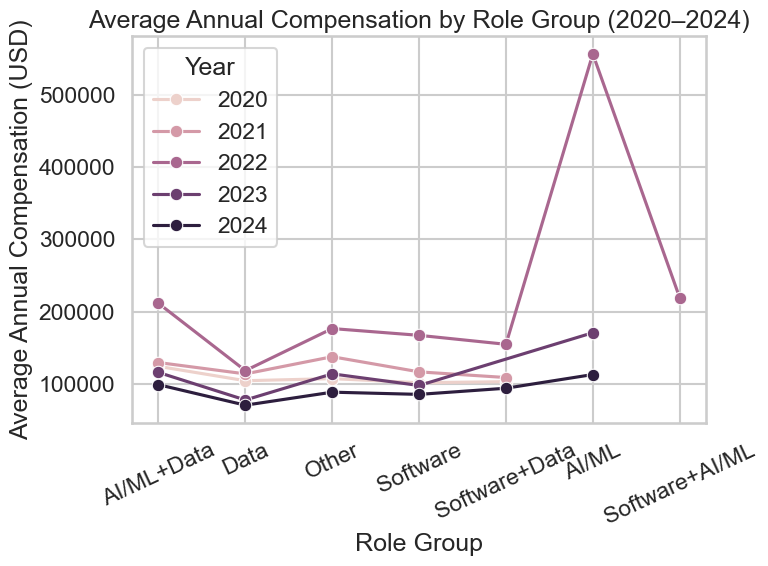

In [69]:
# Combine datasets
combined_df = pd.concat([df_2020, df_2021, df_2022, df_2023, df_2024], ignore_index=True)

# Compute mean AnnualComp per RoleGroup per Year
comp_summary = (
    combined_df.groupby(['Year', 'RoleGroup'])['AnnualComp']
    .mean()
    .reset_index()
)

# Line Plot
plt.figure(figsize=(8, 6))
sns.lineplot(
    data=comp_summary,
    x='RoleGroup',
    y='AnnualComp',
    hue='Year',
    marker='o'
)

plt.title('Average Annual Compensation by Role Group (2020–2024)', fontsize=18)
plt.ylabel('Average Annual Compensation (USD)')
plt.xlabel('Role Group')
plt.xticks(rotation=25)
plt.legend(title='Year')
plt.tight_layout()
plt.show()


### 2️⃣ Bar Chart – Top 10 Programming Languages (2020–2024)
Goal: Compare shifts in language usage over time.

[2020] ⚠️ Column 'LanguageHaveWorkedWith' not found.
✅ langs_df columns: ['Language', 'Count', 'Year']
     Language  Count  Year
0  JavaScript  53587  2021
1    HTML/CSS  46259  2021
2      Python  39792  2021
3         SQL  38835  2021
4        Java  29162  2021


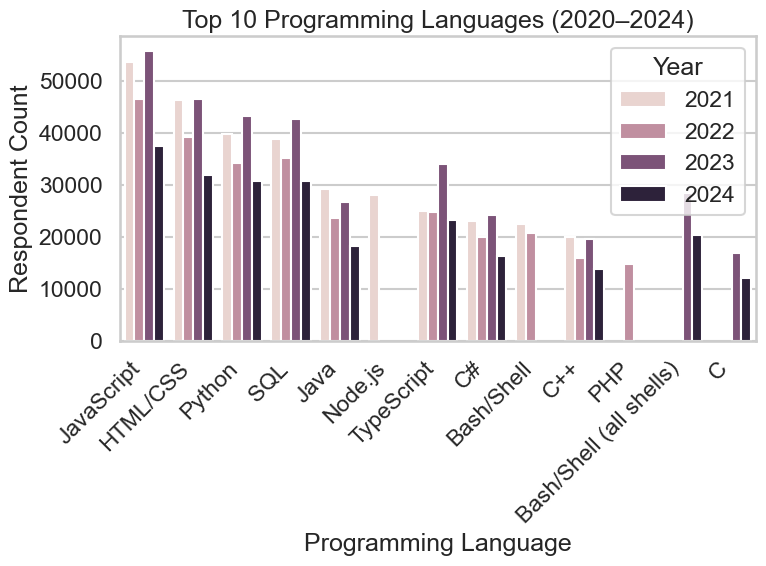

In [70]:
def extract_top_languages(df, year):
    """
    Extract top 10 programming languages for a given year
    from 'LanguageHaveWorkedWith' column.
    """
    if 'LanguageHaveWorkedWith' not in df.columns:
        print(f"[{year}] ⚠️ Column 'LanguageHaveWorkedWith' not found.")
        return pd.DataFrame()

    # Split and count occurrences
    lang_series = (
        df['LanguageHaveWorkedWith']
        .dropna()
        .astype(str)
        .str.split(';')
        .explode()
        .str.strip()
        .value_counts()
        .head(10)
        .reset_index()
    )

    # Properly rename columns
    lang_series.columns = ['Language', 'Count']
    lang_series['Year'] = year
    return lang_series

# Combine all years into one DataFrame
langs_df = pd.concat([
    extract_top_languages(df_2020, 2020),
    extract_top_languages(df_2021, 2021),
    extract_top_languages(df_2022, 2022),
    extract_top_languages(df_2023, 2023),
    extract_top_languages(df_2024, 2024)
], ignore_index=True)

# Confirm structure before plotting
print("✅ langs_df columns:", langs_df.columns.tolist())
print(langs_df.head())

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    data=langs_df,
    x='Language',
    y='Count',
    hue='Year'
)
plt.title('Top 10 Programming Languages (2020–2024)', fontsize=18)
plt.ylabel('Respondent Count')
plt.xlabel('Programming Language')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Year')
plt.tight_layout()
plt.show()


### 3️⃣ Pie Charts – AI Sentiment and AI Threat Perception (2024)
Goal: Developers’ overall attitudes and fears toward AI in 2024.

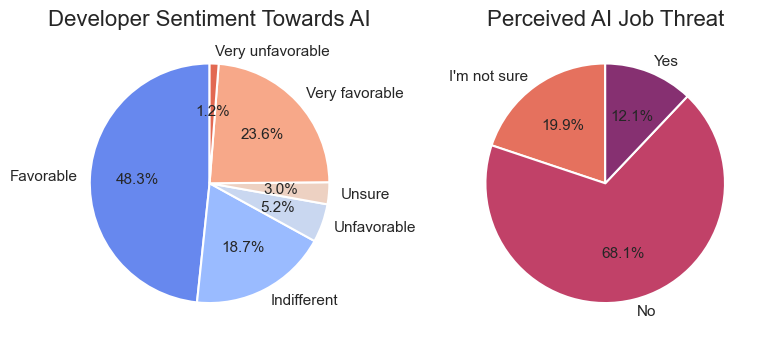

In [78]:
# ---- Focus on 2024 dataset ----
df_ai = df_2024.copy()

# ---- Drop both NaN and "NA"-like values ----
df_ai = df_ai[
    (~df_ai['AISent'].isin(['NA', 'N/A', 'na'])) &
    (~df_ai['AIThreat'].isin(['NA', 'N/A', 'na']))
]

# ---- Drop remaining missing values ----
df_ai_sent = df_ai.dropna(subset=['AISent'])
df_ai_threat = df_ai.dropna(subset=['AIThreat'])

# ---- Count category distributions ----
sent_counts = df_ai_sent['AISent'].value_counts().sort_index()
threat_counts = df_ai_threat['AIThreat'].value_counts().sort_index()

# ---- Define color palettes ----
sent_colors = sns.color_palette("coolwarm", len(sent_counts))
threat_colors = sns.color_palette("flare", len(threat_counts))

# ---- Create side-by-side pie charts ----
fig, axes = plt.subplots(1, 2, figsize=(8, 6))

# 🧠 AI Sentiment Pie
axes[0].pie(
    sent_counts,
    labels=sent_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sent_colors,
    textprops={'fontsize': 11}
)
axes[0].set_title('Developer Sentiment Towards AI', fontsize=16)

# ⚠️ AI Threat Pie
axes[1].pie(
    threat_counts,
    labels=threat_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=threat_colors,
    textprops={'fontsize': 11}
)
axes[1].set_title('Perceived AI Job Threat', fontsize=16)

plt.tight_layout()
plt.show()


### 4️⃣ Median annual compensation per role group (for 2024 only)
Goal: Verify the highest compensation on the basis of role groups.

Median annual compensation per role group (for 2024 only):
 RoleGroup
AI/ML            78686.5
Software+Data    76000.0
AI/ML+Data       73036.0
Software         64968.0
Other            64444.0
Data             59073.0
Name: AnnualComp, dtype: float64


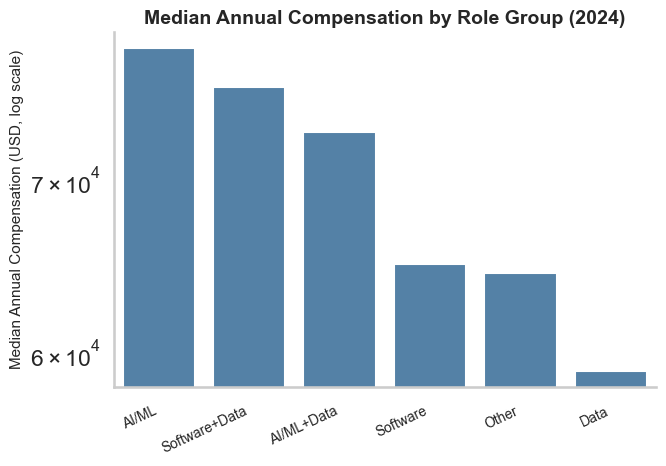

In [77]:
# Median annual compensation per role group (for 2024 only)
print(f"Median annual compensation per role group (for 2024 only):\n {df_2024.groupby('RoleGroup')['AnnualComp'].median().sort_values(ascending=False)}")

# # Mean annual compensation per role group (for 2024 only)
# print(f"Median annual compensation per role group (for 2024 only):\n {df_2024.groupby('RoleGroup')['AnnualComp'].mean().sort_values(ascending=False)}")

# --- Group by RoleGroup for median compensation ---
role_medians = (
    df_2024.groupby('RoleGroup')['AnnualComp']
    .median()
    .reset_index()
    .sort_values(by='AnnualComp', ascending=False)
)

# --- Plot ---
plt.figure(figsize=(7,5))
sns.barplot(
    data=role_medians,
    x='RoleGroup',
    y='AnnualComp',
    color='steelblue',
    errorbar=('pi', 50)  # 50% percentile interval bars, can remove if undesired
)

# --- Style polish ---
plt.yscale('log')  # use log scale since salary data is right-skewed
plt.title('Median Annual Compensation by Role Group (2024)', fontsize=14, weight='bold')
plt.ylabel('Median Annual Compensation (USD, log scale)', fontsize=11)
plt.xlabel('')
plt.xticks(rotation=25, ha='right', fontsize=10)
sns.despine()
plt.tight_layout()
plt.show()



## MODELS

### 1️⃣ Data Preparation

In [72]:
# --- Work on 2024 data for completeness ---
# df = pd.concat([df_2020, df_2021, df_2022, df_2023, df_2024], ignore_index=True)
df = df_2024.copy()

# --- Drop missing AnnualComp and outliers ---
df = df.dropna(subset=['AnnualComp'])
df = df[(df['AnnualComp'] >= 1000) & (df['AnnualComp'] <= 500000)]

# --- Clean and encode numeric variables ---
def clean_years(val):
    if pd.isna(val): return np.nan
    val = str(val)
    if "Less" in val: return 0.5
    elif "More" in val: return 51
    else:
        try: return float(val)
        except: return np.nan

df['YearsCodeProNum'] = df['YearsCodePro'].apply(clean_years)

edu_map = {
    "Less than secondary school (e.g. American high school)": 1,
    "Secondary school (e.g. American high school)": 2,
    "Some college/university study without earning a degree": 3,
    "Associate degree": 4,
    "Bachelor’s degree": 5,
    "Master’s degree": 6,
    "Professional degree (JD, MD, etc.)": 7,
    "Other doctoral degree (Ph.D., Ed.D., etc.)": 8
}
df['EdLevelNum'] = df['EdLevel'].map(edu_map)

size_map = {
    "Just me - I am a freelancer, sole proprietor, etc.": 1,
    "2 to 9 employees": 2,
    "10 to 19 employees": 3,
    "20 to 99 employees": 4,
    "100 to 499 employees": 5,
    "500 to 999 employees": 6,
    "1,000 to 4,999 employees": 7,
    "5,000 to 9,999 employees": 8,
    "10,000 or more employees": 9
}
df['OrgSizeNum'] = df['OrgSize'].map(size_map)

df['RemoteWorkNum'] = df['RemoteWork'].apply(
    lambda x: 1 if isinstance(x, str) and ('remote' in x.lower() or 'hybrid' in x.lower()) else 0
)

# --- Encode skills and AI perception ---
df['UsesPython'] = df['LanguageHaveWorkedWith'].astype(str).str.contains('Python', case=False, na=False).astype(int)
df['UsesSQL'] = df['LanguageHaveWorkedWith'].astype(str).str.contains('SQL', case=False, na=False).astype(int)

sent_map = {
    "Very unfavorable": 1,
    "Unfavorable": 2,
    "Indifferent": 3,
    "Favorable": 4,
    "Very favorable": 5
}
df['AISentNum'] = df['AISent'].map(sent_map)

df['AIThreatNum'] = df['AIThreat'].apply(
    lambda x: 1 if isinstance(x, str) and ('yes' in x.lower()) else 0
)

# --- RoleGroup (one-hot encode) ---
role_dummies = pd.get_dummies(df['RoleGroup'], prefix='Role', drop_first=True)

# --- Final feature set ---
X = pd.concat([
    df[['YearsCodeProNum', 'EdLevelNum', 'OrgSizeNum', 'RemoteWorkNum',
        'UsesPython', 'UsesSQL', 'AISentNum', 'AIThreatNum']],
    role_dummies
], axis=1)
y = df['AnnualComp']


### 2️⃣ Linear Regression Model

In [73]:
# Drop any remaining rows with NaNs in X or y
X = X.dropna()
y = y.loc[X.index]  # keep y aligned

# Train/test split again
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_pred = linreg.predict(X_test)

print("✅ Model successfully trained.")
print(f"Mean Absolute Error: ${mean_absolute_error(y_test, y_pred):,.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")


✅ Model successfully trained.
Mean Absolute Error: $39,353.64
R² Score: 0.254


### Next Step: Coefficient Analysis

C:\Users\Abhiroop Kumar\AppData\Local\Temp\ipykernel_1220\603718845.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


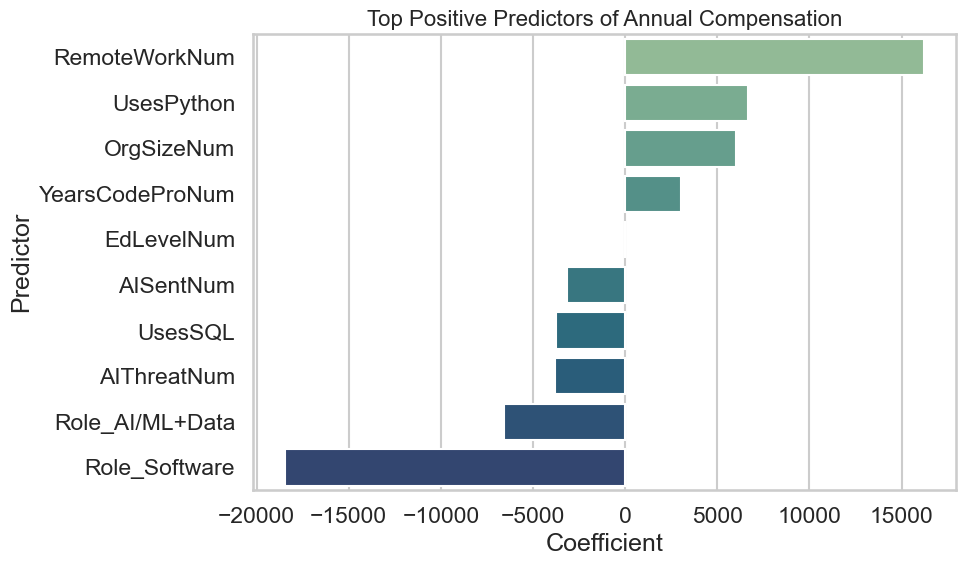

C:\Users\Abhiroop Kumar\AppData\Local\Temp\ipykernel_1220\603718845.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


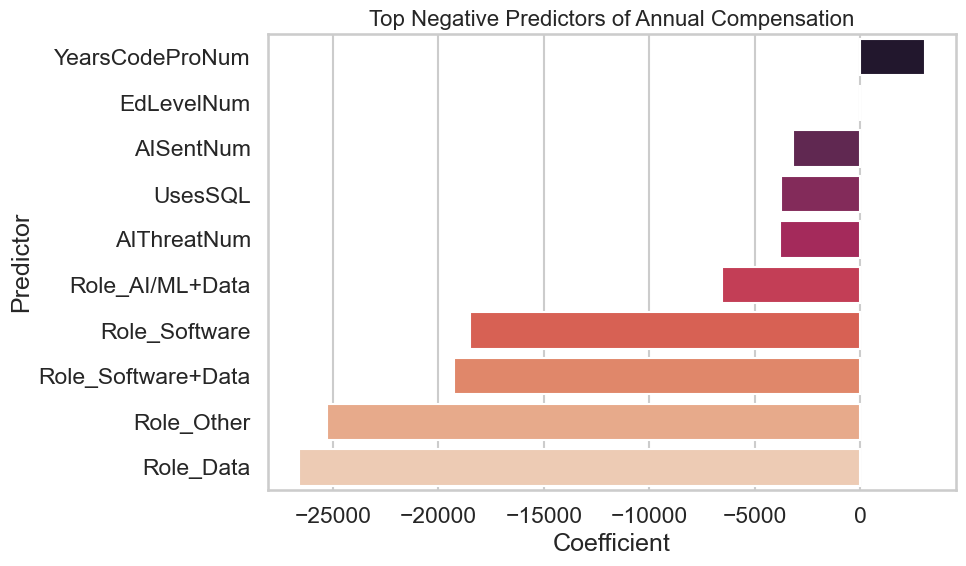

In [74]:
# ---- Coefficients ----
coef_df = pd.DataFrame({
    'Predictor': X.columns,
    'Coefficient': linreg.coef_
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    data=coef_df.head(10),
    x='Coefficient',
    y='Predictor',
    palette='crest'
)
plt.title('Top Positive Predictors of Annual Compensation', fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(
    data=coef_df.tail(10),
    x='Coefficient',
    y='Predictor',
    palette='rocket'
)
plt.title('Top Negative Predictors of Annual Compensation', fontsize=16)
plt.tight_layout()
plt.show()
